# Keras Mobile Net

First of all we install the modules we will need for this project:

In [1]:
#!pip install pillow
#!pip install sklearn
#!pip install keras

(After installing all these modules it's a good idea to restart the kernel)

We import the modules we are going to use:

In [2]:
import keras
import tensorflow as tf
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.utils import to_categorical
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob
import os

Using TensorFlow backend.


**(It's important to check that Keras is using Tensorflow backend)**

We are going to have a look to the input, in order to do that we pick an image and plot it:

In [3]:
img_dir = '/data/common/RaFD/'

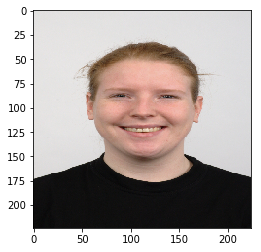

In [4]:
img = image.load_img(os.path.join(img_dir, 'Rafd090_27_Caucasian_female_happy_frontal.jpg'),
                     target_size=(224, 224))
x = image.img_to_array(img)
x.shape
plt.imshow(x/255.);

The dataset will be formed by all these images. In order to train the network we will only select the frontal pictures and those who are only lightly rotated. We split in a training set and a validation set. (The people selected for validation were chosen manually)

In [5]:
files_90 = tf.gfile.Glob(os.path.join(img_dir, 'Rafd090*.jpg'))
files_135 = tf.gfile.Glob(os.path.join(img_dir, 'Rafd135*.jpg'))
files_45 = tf.gfile.Glob(os.path.join(img_dir, 'Rafd045*.jpg'))
files = files_90 + files_45 + files_135

# Create a validation set:
data_test = []
for img_num in ['01', '03', '19', '29', '64']:
    for rot in ['090', '135', '045']:
        data_path = os.path.join(img_dir, 'Rafd{}_{}*.jpg'.format(rot, img_num))
        val_files = tf.gfile.Glob(data_path)
        data_test = data_test + val_files
        
# Create a training set
data_train = [f for f in files if f not in data_test]
print(len(data_test))
print(len(data_train))
print(len(files))

360
4464
4824


Once we have chosen which images will be used to train and which to test we extract the tags and code them as a number:

In [6]:
dic_emotions = dict(zip(['happy', 'angry', 'sad', 'contemptuous', 'disgusted', 'neutral',
                             'fearful', 'surprised'], list(range(0, 8))))

Let's load the images and normalize them:

In [7]:
def crop_center(img,cropx,cropy):
    img = np.array(img)
    y,x,_ = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx,:]

def load_images(files):
    x_data = []
    y_data = []
    for file in files:
        title = file.split("_")
        emotion = title[-2]
        y_data.append(dic_emotions[emotion])
        img = image.load_img(file, target_size=(320, 320))
        x = crop_center(img, 224, 224)
        del img
        x_data.append(x/255.)
    return x_data, y_data

x_train, y_train = load_images(data_train)
x_test, y_test = load_images(data_test)
x_train = np.array(x_train)
x_test = np.array(x_test)

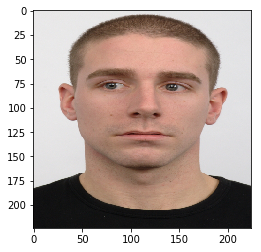

In [8]:
plt.imshow(x_train[10])

We transform the tags to one hot encondig:

In [9]:
encoded_y_train = to_categorical(y_train, num_classes=8, dtype='float32')
encoded_y_test = to_categorical(y_test, num_classes=8, dtype='float32')

Now the data is ready we can start loading the image. Running the previous code in all our data, may eat up a lot of memory resources; therefore, we are going to use a generator.


In [10]:
from sklearn.utils import shuffle
def load_data_generator(x, y, batch_size=64):
    num_samples = x.shape[0]
    while 1:  # Loop forever so the generator never terminates
        try:
            shuffle(x)
            for i in range(0, num_samples, batch_size):
                x_data = [im for im in x[i:i+batch_size]]
                y_data = y[i:i + batch_size]
            
                # convert to numpy array since this what keras required
                yield np.array(x_data), np.array(y_data)
        except Exception as err:
            print(err)

Note that there is a commented line in order to change it if we want to do any kind of preprocessing on the image.

Now we build the model:

In [11]:
from keras.applications import MobileNetV2
from keras.layers import Dense, Input, Dropout, Reshape
from keras.models import Model

def build_model(target_size, input_tensor=None):
    if input_tensor is not None:
        input_tensor = Input(tensor=input_tensor)
    else:
        input_tensor = Input(shape=(target_size, target_size, 3))
        
    base_model = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_tensor=input_tensor,
        pooling='avg')

    for layer in base_model.layers:
        layer.trainable = True  # trainable has to be false in order to freeze the layers
        
    op = Dense(256, activation='relu')(base_model.output)

    output_tensor = Dense(8, activation='softmax')(op) #We set eight neurons since there are 8 emotions.

    model = Model(inputs=input_tensor, outputs=output_tensor)


    return model

We build the model:

We will use the generator to optimize the training:

In [12]:
K.clear_session()
model = build_model(target_size=224)
model.summary()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.5/dist-packages/keras_applications/mobilenet_v2.py:295: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


9412608/9406464 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________

Finally we train the model:

In [13]:
model.fit(x_train, encoded_y_train, batch_size=32, epochs=20,
          validation_data=(x_test, encoded_y_test), 
          callbacks=[keras.callbacks.ModelCheckpoint("model.h5", save_best_only=True, save_weights_only=True)])

Instructions for updating:
Use tf.cast instead.
Train on 4464 samples, validate on 360 samples
Epoch 1/20
4464/4464 [==============================] - 37s 8ms/step - loss: 0.5087 - categorical_accuracy: 0.8181 - val_loss: 0.5415 - val_categorical_accuracy: 0.8222
Epoch 2/20
4464/4464 [==============================] - 27s 6ms/step - loss: 0.1909 - categorical_accuracy: 0.9391 - val_loss: 0.4803 - val_categorical_accuracy: 0.8806
Epoch 3/20
4464/4464 [==============================] - 27s 6ms/step - loss: 0.0902 - categorical_accuracy: 0.9718 - val_loss: 0.2663 - val_categorical_accuracy: 0.9056
Epoch 4/20
4464/4464 [==============================] - 27s 6ms/step - loss: 0.0829 - categorical_accuracy: 0.9758 - val_loss: 0.1677 - val_categorical_accuracy: 0.9583
Epoch 5/20
4464/4464 [==============================] - 27s 6ms/step - loss: 0.0987 - categorical_accuracy: 0.9716 - val_loss: 0.7842 - val_categorical_accuracy: 0.8250
Epoch 6/20
4464/4464 [==============================] - 27s 

Once the model is trained we check the validation accuracy:

In [14]:
model.metrics_names

['loss', 'categorical_accuracy']

In [15]:
model.evaluate(x_test, encoded_y_test)

360/360 [==============================] - 1s 2ms/step


[6.392921680874295, 0.3472222222222222]

# Save model

In [16]:
model.save_weights("model_last.h5")

# Export model

In [17]:
K.clear_session()
K.set_learning_phase(0)

In [18]:
image_input = tf.placeholder(tf.int8, shape=(None,None,3))
image = tf.image.convert_image_dtype(image_input, dtype=tf.float32)
image = tf.image.central_crop(image, 0.7)
image = tf.image.resize_images(image, [224, 224])
images = tf.expand_dims(image, axis=0)

model = build_model(target_size=224, input_tensor=images)
model.load_weights('model.h5')

# summarize model.
model.summary()

Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (1, 224, 224, 3)     0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (1, 225, 225, 3)     0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (1, 112, 112, 32)    864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (1, 112, 112, 32)    128         Conv1[0][0]                      
_____________________________________________________________

In [19]:
!rm -rf /outputs/jorge/emotions_mirror/exported_model/

In [20]:
export_dir = '/outputs/jorge/emotions_mirror/exported_model/'
tf.saved_model.simple_save(
        session=keras.backend.get_session(),
        export_dir=export_dir,
        inputs={'input_image':image_input},
        outputs={t.name:t for t in model.outputs})

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /outputs/jorge/emotions_mirror/exported_model/saved_model.pb


In [21]:
!saved_model_cli show --dir {export_dir} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_image'] tensor_info:
        dtype: DT_INT8
        shape: (-1, -1, 3)
        name: Placeholder:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_2/Softmax:0'] tensor_info:
        dtype: DT_FLOAT
        shape: (1, 8)
        name: dense_2/Softmax:0
  Method name is: tensorflow/serving/predict
